# theCourseForum Data Analysis

By: William Kaiser

Data Design: II Interactive Apps
Exploratory Data Analysis

In [126]:
# imports
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sqlalchemy import create_engine

sns.set_theme(style="whitegrid")

In [127]:
DB_NAME = "tcf_db"
DB_USER = "tcf_django"
DB_HOST = "thecourseforum3-do-user-1470180-0.b.db.ondigitalocean.com"
DB_PORT = 25060

# do not leak the db password
DB_PASSWORD = os.environ.get('DB_PASSWORD') 

connection_string = f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'

# creates an sql engine which represents the database and it's structure
engine = create_engine(connection_string)

# creates an active connection to the database
conn = engine.connect()

conn

In [128]:
# list the database tables
tables = pd.read_sql(
    """
    SELECT table_name
    FROM information_schema.tables
    """,
    conn,
)

print(
    ",\n".join(
        [item for item in tables["table_name"].to_list() if item.find("tcf") != -1]
    )
)

tcf_website_answer,
tcf_website_blogpost,
tcf_website_course,
tcf_website_courseinstructorgrade,
tcf_website_instructor,
tcf_website_instructor_departments,
tcf_website_school,
tcf_website_review,
tcf_website_coursegrade,
tcf_website_question,
tcf_website_savedcourse,
tcf_website_department,
tcf_website_semester,
tcf_website_user_groups,
tcf_website_section,
tcf_website_subdepartment,
tcf_website_section_instructors,
tcf_website_user_user_permissions,
tcf_website_vote,
tcf_website_voteanswer,
tcf_website_user,
tcf_website_votequestion


In [129]:
# getting the data
TABLES = [
  'subdepartment',
  'course',
  'review',
  'coursegrade',
  'department',
  'semester',
  'school',
  'instructor',
]

os.makedirs("../data", exist_ok=True)

for table in TABLES:
    print(f"Table: {table}")
    df = pd.read_sql(f"SELECT * FROM tcf_website_{table}", conn)
    df.to_csv(f"../data/{table}.csv", index=False)

print("Finished!")

Table: subdepartment
Table: course
Table: review
Table: coursegrade
Table: department
Table: semester
Table: school
Table: instructor
Finished!


In [130]:
# importing data from database
courses = pd.read_csv("../data/course.csv", lineterminator='\n') 
grades = pd.read_csv("../data/coursegrade.csv", lineterminator='\n') # needed here for some reason: https://stackoverflow.com/questions/33998740/error-in-reading-a-csv-file-in-pandascparsererror-error-tokenizing-data-c-err
reviews = pd.read_csv("../data/review.csv", lineterminator='\n')
departments = pd.read_csv("../data/department.csv")
subdepartments = pd.read_csv("../data/subdepartment.csv")
semesters = pd.read_csv("../data/semester.csv")
schools = pd.read_csv("../data/school.csv")
instructors = pd.read_csv("../data/instructor.csv")

## Data Selection

theCourseForum provides accurate course reviews and grade distributions for students of the University of Virginia. Presented visualizations are relatively surface-level, however. I would like to explore the data further to better communicate course impact to students and instructors.

## Data Provenience

The data comes from [theCourseForum](https://thecourseforum.com/) which is a student organization which collects course review data and grade distributions from students the University of Virginia.


# Cleaning the Data

Cleaning the data will require consolidation of many of the data tables. There will still be more than one-data table, but it will be stored in an expanded form. This will allow for easier data manipulation and visualization. This will include:

- Merging course review and subdepartment data
- Merging course review and instructor data

In [131]:
# making the big data table
# don't read to much into this cell
# the output works, but the code is a containerized mess
data = pd.merge(courses, grades, left_on="id", right_on="course_id")
data = pd.merge(data, subdepartments, left_on="subdepartment_id", right_on="id")
data = pd.merge(
    data, reviews, left_on="id_x", right_on="course_id", suffixes=("_course", "_review")
)
data = pd.merge(data, semesters, left_on="semester_id", right_on="id")
data = pd.merge(
    data,
    instructors,
    left_on="instructor_id",
    right_on="id",
    suffixes=("_semester", "_instructor"),
)

data = data.drop(
    columns=[
        "id_instructor",
        "id_y",
        "website",
        "course_id_course",
        "department_id",
        "instructor_id",
        "modified",
        "id_review",
        "id_course",
        "id_semester",
        "subdepartment_id",
        "semester_id",
        "course_id_review",
        "user_id",
        "number_y",
        "description_y",
    ]
)
data = data.rename(
    columns={
        "id_x": "course_id",
        "description_x": "description",
        "number_x": "course_number",
        "created": "review_created",
        "email": "instructor_email",
        "text": "review_text",
        "name": "subdepartment_name",
    }
)
data['instructor_name'] = data['first_name'].str.strip() + " " + data['last_name'].str.strip()

# hiding data
data = data[data["hidden_semester"] == False]
data = data.drop(columns=["hidden_semester", "hidden_instructor", "first_name", "last_name"])
data.reset_index(drop=True, inplace=True)

# getting the semester last taught
data = pd.merge(data, semesters, left_on="semester_last_taught_id", right_on="id", suffixes=("", "_last_taught"), how="left")
data = data.drop(columns=["id", "semester_last_taught_id", "number"])
# data
print(data.columns)
data.head()

Index(['course_id', 'title', 'description', 'course_number', 'average',
       'a_plus', 'a', 'a_minus', 'b_plus', 'b', 'b_minus', 'c_plus', 'c',
       'c_minus', 'total_enrolled', 'dfw', 'subdepartment_name', 'mnemonic',
       'review_text', 'instructor_rating', 'difficulty', 'recommendability',
       'enjoyability', 'hours_per_week', 'amount_reading', 'amount_writing',
       'amount_group', 'amount_homework', 'review_created', 'year', 'season',
       'instructor_email', 'instructor_name', 'year_last_taught',
       'season_last_taught'],
      dtype='object')


,course_id,title,description,course_number,average,a_plus,a,a_minus,b_plus,b,...,amount_writing,amount_group,amount_homework,review_created,year,season,instructor_email,instructor_name,year_last_taught,season_last_taught
0,12,Introductory Accounting I,Designed to introduce students to the language...,2010,3.200437,59,131,51,42,62,...,3,4,2,2020-11-10 22:11:29+00:00,2020,FALL,gdb5x@virginia.edu,Gary Brooks,2023,SPRING
1,1505,History and Civilization of Classical India,Studies the major elements of South Asian civi...,2001,3.395795,5,85,132,117,66,...,1,0,0,2020-12-19 04:08:23.637939+00:00,2020,FALL,sal9c@virginia.edu,Spencer Leonard,2021,FALL
2,1504,Introductory Seminar in South Asia,Introduction to the study of history intended ...,1501,3.601403,9,118,131,74,27,...,0,0,0,2016-11-02 16:38:11+00:00,2016,FALL,sal9c@virginia.edu,Spencer Leonard,2022,SPRING
3,1505,History and Civilization of Classical India,Studies the major elements of South Asian civi...,2001,3.395795,5,85,132,117,66,...,0,0,0,2021-12-20 18:54:54.439844+00:00,2021,FALL,sal9c@virginia.edu,Spencer Leonard,2021,FALL
4,15083,India From Akbar to Victoria,Studies the society and politics in the Mughal...,3002,2.984615,0,2,6,1,1,...,1,0,0,2022-11-03 03:15:03.409391+00:00,2021,FALL,sal9c@virginia.edu,Spencer Leonard,2021,FALL


In [132]:
# saving the cleaned data
data.to_csv("../data.csv", index=False)

In [133]:
# convert `created` and `modified` into a date object
reviews["created"] = pd.to_datetime(reviews["created"], format="mixed").dt.date
reviews["modified"] = pd.to_datetime(reviews["modified"], format="mixed").dt.date

In [134]:
courses

,id,title,description,number,semester_last_taught_id,subdepartment_id
0,19,Selected Topics in Advanced Accounting,Studies accounting and financial reporting for...,5310,60,2
1,7553,Research in Single-Molecule Imaging,Research in Single-Molecule Imaging,9740,60,30
2,10376,Historiography of Early Modern South Asia,Analyzes historical sources and historians of ...,5021,20,88
3,7554,Research in Bioanalytical Microsystems,Students will conduct research in bioanalytica...,9760,60,30
4,1090,Introduction to Old English,Studies the language and literature of Anglo-S...,5010,32,55
...,...,...,...,...,...,...
15752,1286,Corporate Financial Strategies,This course adopts the perspective of a CFO of...,8423,60,71
15753,1301,Corporate Financing,The course focuses on capital raising in the U...,8470,60,71
15754,10974,Philosophy and Business: Business in Society,The purpose of this course is to enable the st...,8489,60,71
15755,1302,Special Topics Seminar,Each seminar is a course of study for students...,8500,60,71


In [135]:
# only using grades with averages
grades.dropna(subset=["average"], inplace=True)
grades

,id,average,a_plus,a,a_minus,b_plus,b,b_minus,c_plus,c,c_minus,total_enrolled,course_id,dfw
0,66999,3.435240,21,507,494,261,222,88,45,36,23,1748,1.0,51
3,67002,3.223230,0,17,23,17,24,11,7,3,2,106,4.0,2
4,67003,3.529115,110,599,353,185,111,67,20,31,24,1600,5.0,74
6,67005,3.640000,2,13,18,14,8,0,1,0,0,57,7.0,1
7,67006,3.169084,16,54,54,37,28,17,6,7,13,260,8.0,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12151,79150,3.860000,4,21,2,0,0,1,0,0,1,29,15290.0,0
12152,79151,3.790000,0,10,10,1,1,0,0,0,0,22,15291.0,0
12153,79152,3.278462,0,6,5,9,2,1,0,1,0,26,10243.0,2
12154,79153,3.710000,2,14,5,1,2,0,0,0,0,25,15292.0,1


In [136]:
# List of columns to generate averages for.
columns_to_avg = [
    "instructor_rating",
    "difficulty",
    "recommendability",
    "enjoyability",
    "hours_per_week",
    "amount_reading",
    "amount_writing",
    "amount_group",
    "amount_homework",
]

# Creates a frame, grouped by course_id, and takes the averages.
avg_frame = reviews.groupby("course_id")[columns_to_avg].mean()
# Renames the columns: e.g., difficulty => avg_difficulty
avg_frame.columns = [f"avg_{col_name}" for col_name in avg_frame.columns]

# Performs a left join. Every course stays here, but only courses with reviews will have non-NaN averages.
courses = courses.merge(avg_frame, left_index=True, right_index=True, how="left")

# Adds a new column called "avg_overall"
courses["avg_overall"] = courses.loc[
    :, ["avg_recommendability", "avg_enjoyability", "avg_instructor_rating"]
].mean(axis=1)

# Adds a new column called "num_reviews"
num_reviews = reviews.groupby("course_id")["course_id"].count()

courses["num_reviews"] = num_reviews.astype(np.int64)
courses["num_reviews"] = courses["num_reviews"].fillna(0)

# Include grades data.
gpa = grades[["average", "course_id"]]  # just select the gpa
gpa.columns = ["gpa", "course_id"]  # rename average -> gpa
# Performs a left join. Every course stays here, but only courses with CourseGrades will have non-NaN GPAs
courses = courses.merge(gpa, left_index=True, right_on="course_id", how="left")

# Drop courses that don't have reviews/grades. If you don't want to do this, comment out the next line.
courses = courses.dropna(axis=0)

# Exploratory Data Analysis

## Basic Data / Column Analysis

What is contained in:

- `courses`
- `grades`
- `reviews`

## Open Questions

Looking at the data, I would like to explore the following questions:

### Course Ratings

- What is the distribution of average instructor rating?
- What is the distribution of average course difficult rating by instructor?

### Grade Inflation

- Does UVA have a grade inflation problem? If so, to what extent?
- What is the relationship between course gpa and instructor rating?

### Fun Stuff

- What are the most popular courses at UVA with a significant number of reviews?


In [137]:
reviews.head()

,id,text,instructor_rating,difficulty,recommendability,enjoyability,hours_per_week,amount_reading,amount_writing,amount_group,amount_homework,created,modified,course_id,instructor_id,semester_id,user_id,hidden
0,1,Not a bad class. You won't need your book. M...,3,4,4,3,1,0,0,0,1,2005-07-29,2005-07-29,748,742,6,1,False
1,2,Really enjoyed this class. Tests are a little...,4,3,5,4,1,0,0,0,1,2005-07-30,2005-07-30,749,739,6,1,False
2,3,GO TO CLASS! Even if it's at 9 am. Just readin...,3,5,4,2,4,4,0,0,0,2005-08-05,2005-08-05,6537,355,6,2,False
3,4,Good class. Grades are all based on quiz score...,4,4,5,3,2,2,0,0,0,2005-08-06,2005-08-06,468,465,1,2,False
4,5,"If you have to take chem, you might as well ta...",4,4,4,3,2,2,0,0,0,2005-08-06,2005-08-06,7505,465,6,2,False


## Course Rating


0.065236520314349


Text(0, 0.5, 'Weighted # of Professors')

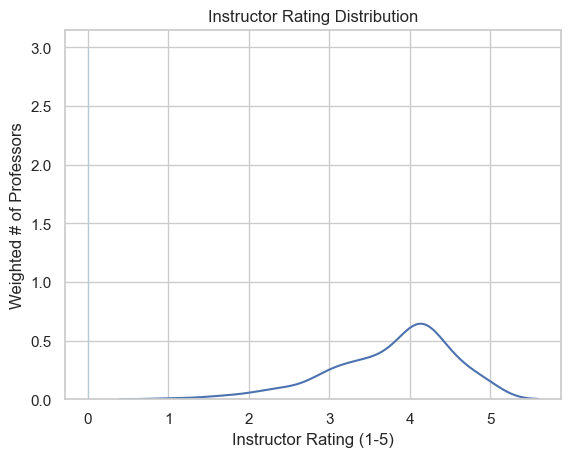

In [138]:
grouped = reviews.groupby("instructor_id")["instructor_rating"]
count = grouped.count()
mean = grouped.mean()
review_data = pd.DataFrame({"mean": mean, "count": count})

# sns.histplot(data=review_data, x='mean', weights='count', kde=True, fill=False, element="poly",common_bins=False, discrete=False, common_norm=False, color='blue')
target_value = "2.04"
sns.kdeplot(data=review_data, x="mean", weights="count")

# y = sns.kdeplot(review_data, x='mean', weights='count', cumulative=True).evaluate(target_value)
plt.fill_between(
    [0], [3], color="skyblue", alpha=0.3, label=f"CDF up to {target_value}"
)


def prof_cdf(item: float) -> float:
    """
    A cumulative density function of professor ratings.

    In effect, you are asking, what % of professors have a rating below X
    """

    def apply_count(row):
        return row["count"] if row["mean"] <= item else 0

    return review_data.apply(apply_count, axis=1).sum() / review_data["count"].sum()


print(prof_cdf(2.5))
plt.title("Instructor Rating Distribution")
plt.xlabel("Instructor Rating (1-5)")
plt.ylabel("Weighted # of Professors")

/Users/wkaiser/miniforge3/envs/tf/lib/python3.8/site-packages/seaborn/distributions.py:416: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)


Text(0, 0.5, '# of Professors')

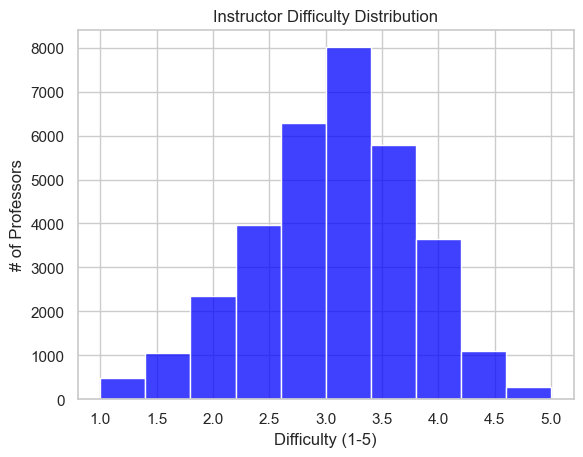

In [139]:
grouped = reviews.groupby("instructor_id")["difficulty"]
count = grouped.count()
mean = grouped.mean()
review_data = pd.DataFrame({"mean": mean, "count": count})

sns.histplot(data=review_data, x="mean", weights="count", kde=False, color="blue")

plt.title("Instructor Difficulty Distribution")
plt.xlabel("Difficulty (1-5)")
plt.ylabel("# of Professors")

## Grade Inflation

Does UVA have grade inflation? If so, does grade inflation correlate with instructor rating?


/Users/wkaiser/miniforge3/envs/tf/lib/python3.8/site-packages/seaborn/distributions.py:416: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Average Grade Distribution by Enrolled Student Population')

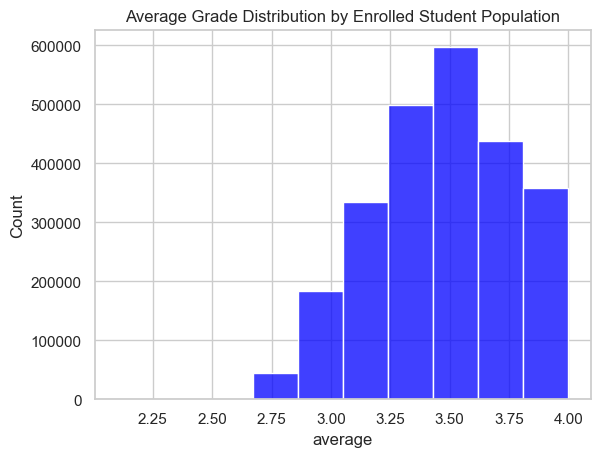

In [140]:
sns.histplot(
    data=grades, x="average", weights="total_enrolled", kde=False, color="blue"
).set_title("Average Grade Distribution by Enrolled Student Population")

(2.0, 4.0)

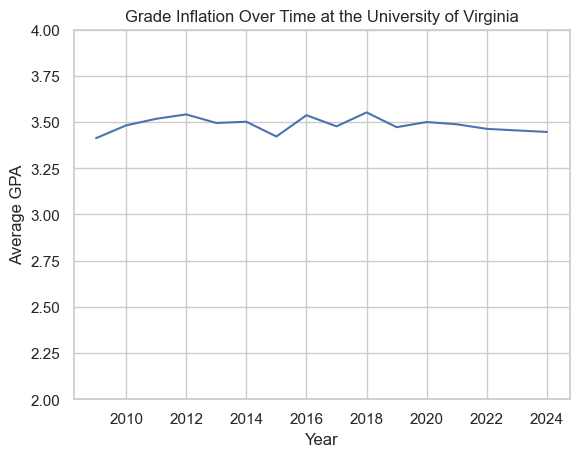

In [141]:
# Grade inflation over time
grade_inflation_over_time = pd.read_sql(
    """
select sum(average * total_enrolled) / sum(total_enrolled) as avg_gpa, s.year from (select average, total_enrolled, semester_last_taught_id from tcf_website_course c join tcf_website_coursegrade g on g.course_id = c.id where g.average > 1) g join tcf_website_semester s on s.id = g.semester_last_taught_id group by s.year;
    """,
    conn,
)

sns.lineplot(data=grade_inflation_over_time, x="year", y="avg_gpa").set_title(
    "Grade Inflation Over Time at the University of Virginia"
)

plt.ylabel("Average GPA")
plt.xlabel("Year")
plt.ylim(2, 4)

In [142]:
columns_to_avg = [
    "instructor_rating",
    "difficulty",
    "recommendability",
    "enjoyability",
    "hours_per_week",
    "amount_reading",
    "amount_writing",
    "amount_group",
    "amount_homework",
]
avg_rating_per_id = reviews.groupby("course_id")[columns_to_avg].mean()

new_grades = grades.set_index("course_id").join(avg_rating_per_id)

new_grades = new_grades.dropna(subset=["average", "instructor_rating"])
new_grades

,id,average,a_plus,a,a_minus,b_plus,b,b_minus,c_plus,c,...,dfw,instructor_rating,difficulty,recommendability,enjoyability,hours_per_week,amount_reading,amount_writing,amount_group,amount_homework
course_id,,,,,,,,,,,,,,,,,,,,,
1.0,66999,3.435240,21,507,494,261,222,88,45,36,...,51,4.700000,2.200000,4.700000,4.500000,3.100000,2.200000,0.900000,0.000000,0.000000
4.0,67002,3.223230,0,17,23,17,24,11,7,3,...,2,4.000000,3.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5.0,67003,3.529115,110,599,353,185,111,67,20,31,...,74,4.111111,2.666667,4.111111,3.555556,5.000000,2.888889,1.333333,0.222222,0.555556
7.0,67005,3.640000,2,13,18,14,8,0,1,0,...,1,2.666667,3.666667,3.333333,3.000000,4.333333,2.666667,1.000000,0.666667,0.000000
8.0,67006,3.169084,16,54,54,37,28,17,6,7,...,28,5.000000,2.000000,4.000000,4.000000,7.000000,2.000000,3.000000,2.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15354.0,79069,3.580000,0,24,34,11,4,2,0,0,...,1,3.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000
15405.0,79117,3.550000,5,8,1,2,2,1,0,0,...,1,4.666667,4.666667,4.000000,3.333333,5.666667,1.000000,3.666667,0.000000,1.000000
15408.0,79119,3.120000,0,6,5,7,6,4,3,0,...,1,5.000000,4.000000,3.000000,3.000000,9.000000,0.000000,0.000000,0.000000,9.000000


Correlation between grades and instructor rating: 0.2560494648361272


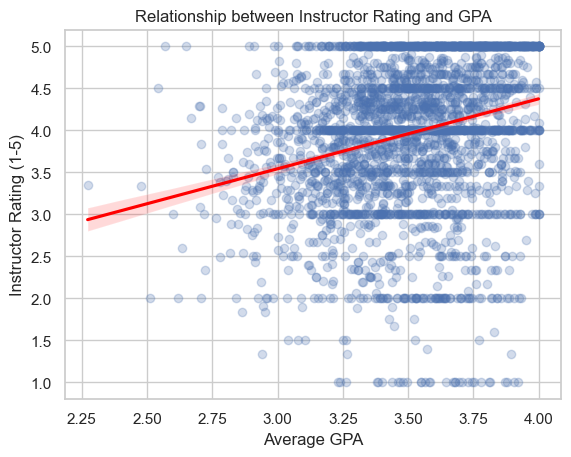

In [143]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatterplot with trendline
sns.regplot(
    data=new_grades,
    x="average",
    y="instructor_rating",
    scatter_kws={"alpha": 0.25},
    line_kws={"color": "red"},
)

plt.title("Relationship between Instructor Rating and GPA")
plt.xlabel("Average GPA")
plt.ylabel("Instructor Rating (1-5)")

# Calculating correlation
correlation = new_grades["average"].corr(new_grades["instructor_rating"])
print("Correlation between grades and instructor rating:", correlation)

plt.show()

## Fun Stuff

Puttering around the dataset to find any other interesting insights or tidbits.


In [144]:
TOP_K_COURSES = 30

num_reviews = reviews.groupby("course_id")["course_id"].count()

courses["num_reviews"] = num_reviews.astype(np.int64)
courses["num_reviews"] = courses["num_reviews"].fillna(0)

courses[courses.num_reviews >= 100].sort_values("avg_instructor_rating")[
    ["title", "description", "avg_instructor_rating"]
].iloc[-TOP_K_COURSES:].iloc[::-1]

,title,description,avg_instructor_rating
7505.0,Grant Writing for Healthcare Program Evaluation,Interactive workshop-type introduction to the ...,4.750000
1055.0,Intermediate Hindi,Introduction to various types of written and s...,4.566038
269.0,Contemporary Disability Theory,This seminar offers an interdisciplinary appro...,4.240000
544.0,Practicum,Supervised field experiences under the directi...,4.200000
270.0,Constitutional History I: From the Revolution ...,The history and historiography of American co...,4.130435
7151.0,New Course in Global Environments and Sustaina...,This course provides the opportunity to offer ...,4.000000
1879.0,New Course in Judaism,This course provides the opportunity to offer ...,4.000000
547.0,Disorders of Communication: Augmentative and A...,A lecture-demonstration course that introduces...,4.000000
553.0,Acting: Production and Performance,"Participation in the production program, credi...",3.826087
543.0,Civil Society in Twentieth Century U.S.,Tocqueville famously described the U.S. of the...,3.821429


Text(0, 0.5, 'Weighted # of Reviews')

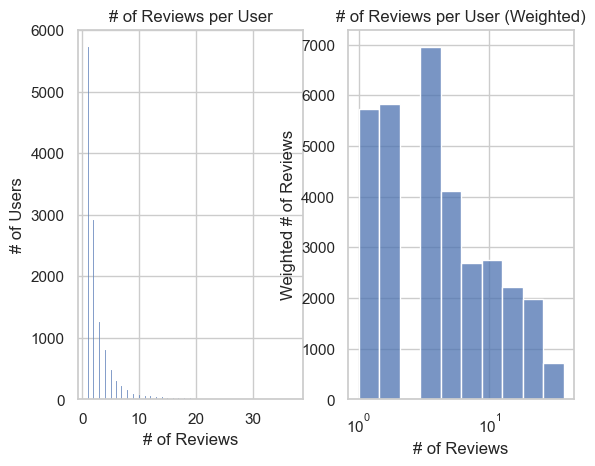

In [145]:
# Super Reviewers and their Disproportionate Influence
data = reviews.groupby("user_id").count().sort_values("id", ascending=False)

fig, ax = plt.subplots(1, 2)
sns.histplot(data=data, x="id", ax=ax[0])
sns.histplot(data=data, x="id", weights="id", bins=10, ax=ax[1], log_scale=True)

ax[0].set_title("# of Reviews per User")
ax[0].set_xlabel("# of Reviews")
ax[0].set_ylabel("# of Users")
ax[1].set_title("# of Reviews per User (Weighted)")
ax[1].set_xlabel("# of Reviews")
ax[1].set_ylabel("Weighted # of Reviews")
# Note: super reviewers account for a disproportionate amount of reviews

In [146]:
# getting the semester data
tables = pd.read_sql(
    """
    SELECT table_name
    FROM information_schema.tables
    """,
    conn,
)

print(
    ",\n ".join(
        [item for item in tables["table_name"].to_list() if item.find("tcf") != -1]
    )
)

tcf_website_answer,
 tcf_website_blogpost,
 tcf_website_course,
 tcf_website_courseinstructorgrade,
 tcf_website_instructor,
 tcf_website_instructor_departments,
 tcf_website_school,
 tcf_website_review,
 tcf_website_coursegrade,
 tcf_website_question,
 tcf_website_savedcourse,
 tcf_website_department,
 tcf_website_semester,
 tcf_website_user_groups,
 tcf_website_section,
 tcf_website_subdepartment,
 tcf_website_section_instructors,
 tcf_website_user_user_permissions,
 tcf_website_vote,
 tcf_website_voteanswer,
 tcf_website_user,
 tcf_website_votequestion


# How many observations do you have?
How many unique categories are there for categorical variables?
How much missing data is there per observation or per variable?
What are the distributions of continuous variables? Are there outliers?

When looking at the data, I notice that "super" reviewers have a disproportionate impact on an instructor's rating. People who have taken the time to review multiple courses may be more opinionated than the average student. This would form a potential caveat to the data.

One thing that shocked me was how predictive grades were of course outcome. In total, the variation in course grade predicts 25% in the variation in reviews. This cynically suggests that "bribing" students with high grades is a good way to get reviews. This further motivates me to seek out who are the professors with lower grades, yet still have high reviews. What makes them different?

Looking at grade distributions by semester, the fact that virtually no grade inflation has occurred in the last 10 years is surprising. This is very contrary to media reports and the general perception of grade inflation at American universities. 

For instance, Havard's grade inflation:

![Havard Grade Inflation](../imgs/grade-inflation.png)


# Data Dictionary

| Table Name | Column Name             | Type     | Label                                                   |
| ---------- | ----------------------- | -------- | ------------------------------------------------------- |
| Grades     | id                      | int64    | Unique identifier for each grade record.                |
| Grades     | average                 | float64  | The average grade for the course.                       |
| Grades     | a_plus                  | int64    | Count of A+ grades awarded.                             |
| Grades     | a                       | int64    | Count of A grades awarded.                              |
| Grades     | a_minus                 | int64    | Count of A- grades awarded.                             |
| Grades     | b_plus                  | int64    | Count of B+ grades awarded.                             |
| Grades     | b                       | int64    | Count of B grades awarded.                              |
| Grades     | b_minus                 | int64    | Count of B- grades awarded.                             |
| Grades     | c_plus                  | int64    | Count of C+ grades awarded.                             |
| Grades     | c                       | int64    | Count of C grades awarded.                              |
| Grades     | c_minus                 | int64    | Count of C- grades awarded.                             |
| Grades     | total_enrolled          | int64    | Total number of students enrolled in the course.        |
| Grades     | course_id               | float64  | Identifier for the course associated with the grades.   |
| Grades     | dfw                     | int64    | Count of students who dropped, failed, or withdrew.     |
| Reviews    | id                      | int64    | Unique identifier for each review record.               |
| Reviews    | text                    | string   | Text content of the review.                             |
| Reviews    | instructor_rating       | int64    | Rating given to the instructor.                         |
| Reviews    | difficulty              | int64    | Difficulty rating of the course.                        |
| Reviews    | recommendability        | int64    | Rating of the course's recommendability.                |
| Reviews    | enjoyability            | int64    | Enjoyability rating of the course.                      |
| Reviews    | hours_per_week          | int64    | Estimated number of study hours required per week.      |
| Reviews    | amount_reading          | int64    | Amount of reading required for the course.              |
| Reviews    | amount_writing          | int64    | Amount of writing required for the course.              |
| Reviews    | amount_group            | int64    | Amount of group work required for the course.           |
| Reviews    | amount_homework         | int64    | Amount of homework required for the course.             |
| Reviews    | created                 | datetime | Date and time when the review was created.              |
| Reviews    | modified                | datetime | Date and time when the review was last modified.        |
| Reviews    | course_id               | int64    | Identifier for the course being reviewed.               |
| Reviews    | instructor_id           | int64    | Identifier for the instructor being reviewed.           |
| Reviews    | semester_id             | int64    | Identifier for the semester when the course was taken.  |
| Course     | id                      | int64    | Unique identifier for each course record.               |
| Course     | title                   | string   | Title of the course.                                    |
| Course     | description             | string   | Description of the course.                              |
| Course     | number                  | int64    | Course number or code.                                  |
| Course     | semester_last_taught_id | int64    | Identifier for the last semester the course was taught. |
| Course     | subdepartment_id        | int64    | Identifier for the subdepartment offering the course.   |
| semester   | id          | int64  | Unique identifier             |
| semester   | year        | int64  | Year of the semester          |
| semester   | season      | string | Season of the semester (SPRING, SUMMER, FALL, WINTER)  |
| semester   | number      | int64  | Semester number within a year |
| school     | id          | int64  | Unique identifier |
| school     | name        | string | Name of the school |
| school     | description | string | Description of the school |
| school     | website     | url    | Website URL of school      |
| department | id          | int64  | Unique identifier |
| department | name        | object | Name of the department |
| department | description | object | Description of the department |
| department | website     | object | Website URL of the department |
| department | school_id   | int64  | Foreign key referencing school id |


However, if you want an updated data dictionary of the merged data, that is the following:

| Column Name        | Type     | Description                                                                                                                                    |
| ------------------ | -------- | ---------------------------------------------------------------------------------------------------------------------------------------------- |
| course_id          | float64  | Identifier for the course, from the review                                                                |
| title              | string   | Title of the course, sourced from the Course table.                                                                                            |
| description        | string   | Description of the course, sourced from the Course table.                                                                                      |
| course_number      | int64    | Course number or code, sourced from the Course table.                                                                                   |
| average            | float64  | The average grade for the course, sourced from the Grades table.                                                                               |
| a_plus             | int64    | Count of A+ grades awarded, sourced from the Grades table.                                                                                     |
| a                  | int64    | Count of A grades awarded, sourced from the Grades table.                                                                                      |
| a_minus            | int64    | Count of A- grades awarded, sourced from the Grades table.                                                                                     |
| b_plus             | int64    | Count of B+ grades awarded, sourced from the Grades table.                                                                                     |
| b                  | int64    | Count of B grades awarded, sourced from the Grades table.                                                                                      |
| b_minus            | int64    | Count of B- grades awarded, sourced from the Grades table.                                                                                     |
| c_plus             | int64    | Count of C+ grades awarded, sourced from the Grades table.                                                                                     |
| c                  | int64    | Count of C grades awarded, sourced from the Grades table.                                                                                      |
| c_minus            | int64    | Count of C- grades awarded, sourced from the Grades table.                                                                                     |
| total_enrolled     | int64    | Total number of students enrolled in the course, sourced from the Grades table.                                                                |
| dfw                | int64    | Count of students who dropped, failed, or withdrew, sourced from the Grades table.                                                             |
| subdepartment_name | string   | Name of the subdepartment offering the course from the subdepartments table                                            |
| mnemonic           | string   | An abbreviation or unique identifier for the course's subdepartment.                               |
| review_text        | string   | Text content of the review, sourced from the Reviews table.                                                                                    |
| instructor_rating  | int64    | Rating given to the instructor, sourced from the Reviews table.                                                                                |
| difficulty         | int64    | Difficulty rating of the course, sourced from the Reviews table.                                                                               |
| recommendability   | int64    | Rating of the course's recommendability, sourced from the Reviews table.                                                                       |
| enjoyability       | int64    | Enjoyability rating of the course, sourced from the Reviews table.                                                                             |
| hours_per_week     | int64    | Estimated number of study hours required per week, sourced from the Reviews table.                                                             |
| amount_reading     | int64    | Amount of reading required for the course, sourced from the Reviews table.                                                                     |
| amount_writing     | int64    | Amount of writing required for the course, sourced from the Reviews table.                                                                     |
| amount_group       | int64    | Amount of group work required for the course, sourced from the Reviews table.                                                                  |
| amount_homework    | int64    | Amount of homework required for the course, sourced from the Reviews table.                                                                    |
| review_created     | datetime | Date and time when the review was created, adjustment of 'created' from Reviews table.                                                         |
| year               | int64    | Year of the semester when the course was taken, sourced from the semester table.                                                               |
| season             | string   | Season of the semester when the course was taken (SPRING, SUMMER, FALL, WINTER), sourced from the semester table.                              |
| instructor_email   | string   | Email of the instructor, from the instructor table                                                                 |
| instructor_name    | string   | Name of the instructor, from the instructor table                                              |
| year_last_taught   | int64    | Year of the last semester the course was taught, indicating recency and derived from semester_last_taught_id in the Course table.     |
| season_last_taught | string   | Season of the last semester the course was taught, indicating recency, from the semester_last_taught_id in the Course table. |

> Note: used [Spreadsheet to Markdown](https://tabletomarkdown.com/convert-spreadsheet-to-markdown/) to convert the data dictionary from a spreadsheet to markdown.


Finally, brainstorm a list of UI components that you could include in your dashboard. Consider what would be most useful or interesting for users.

Also brainstorm a list 3-6 possible data visualizations (e.g., a scatter plot of sepal length vs sepal width - this could be filtered on species using a multi-select dropdown)



# UI Components Possible Given the Dataset

1. A course search bar
2. Filtering Courses By Number of Reviews
3. Filtering Courses By AVG GPA
4. Filtering Courses
5. Filtering by department

## Possible Data Visualizations

1. t-SNE visualization of courses and course reviews using model embeddings
2. Scatter plot of course rating vs a bunch of factors
3. A breakdown of how adding more features into the prediction algorithm 
4. A table and bar chart showing the most popular courses at UVA
5. A bar chart showing the distribution of course ratings within a department

<p align="center">Please let me know if you have any questions!</p>

In [147]:
# making sure the review data submitted is anonymized and not identifiable before contributing to the public repository
if 'user_id' in reviews.columns:
    reviews.drop(columns=['user_id'], inplace=True)
    reviews.to_csv("../data/review.csv", index=False)

# filtering and dropping hidden
if 'hidden' in reviews.columns:
    reviews = reviews[reviews['hidden'] == False]
    reviews.drop(columns=['hidden'], inplace=True)
    reviews.to_csv("../data/review.csv", index=False)

/var/folders/m0/sl2yvpv551gcfbk3gdntf74r0000gn/T/ipykernel_80012/1648067031.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews.drop(columns=['hidden'], inplace=True)
